### Načteme data

In [1]:
import os

PATH = os.path.join("datasets", "04", "titanic")

In [2]:
import pandas as pd

def load_data(file, path=PATH):
    csv = os.path.join(path, file)
    return pd.read_csv(csv)


In [3]:
train = load_data("train.csv")
test = load_data("test.csv")

Test data zde neobsahují cílové hodnoty - to je naším úkolem predikovat a nahrát na Kaggle. 

Trénovací data pro jistotu zamícháme

In [4]:
import numpy as np
np.random.shuffle(train.values)

### Prozkoumáme data

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Význam méně jasných atributů:
- SibSp: kolik sourozenců a manželů tohoto pasažéra bylo na palubě
- Parch: kolik dětí a rodičů tohoto pasažéra bylo na palubě
- Fare: cena za lístek
- Cabin: číslo kajuty
- Embarked: kde pasažér nastoupil na plavbu


Vidíme, že věk, cabin a embarked nemáme u všech. S tím si budeme muset poradit.
- věk nahradíme mediánem
- cabin nám ve většině případů chybí, podíváme se později co s tím
- embarked nám chybí jen v pár případech, použijeme nejčastější hodnotu

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

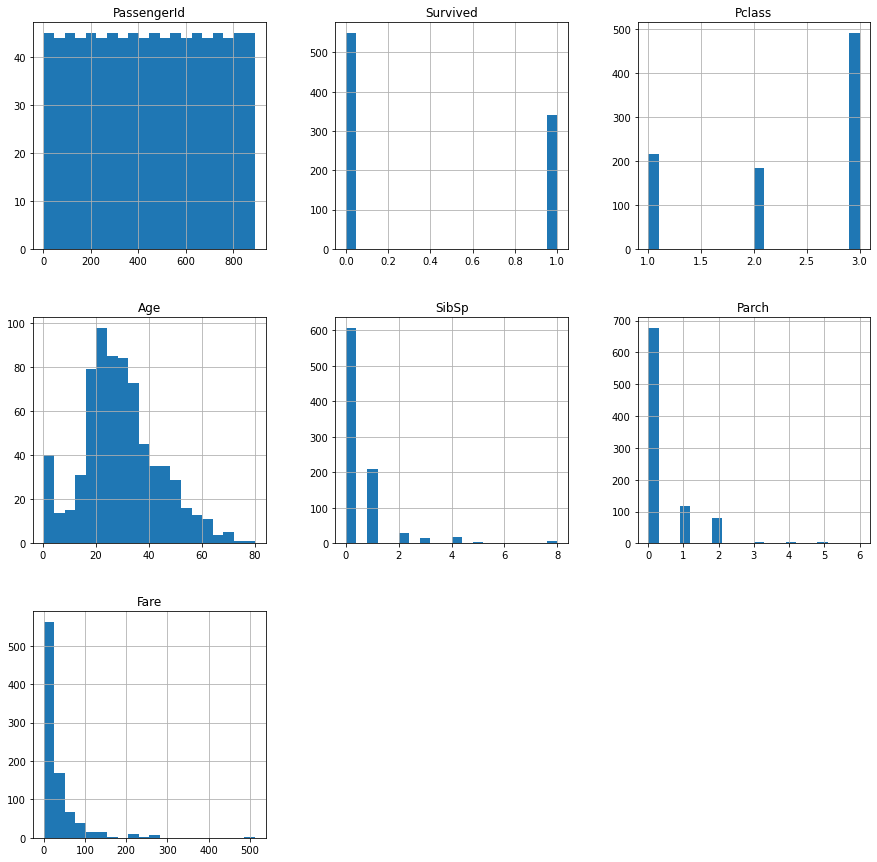

In [8]:
train.hist(figsize=(15,15), bins=20)

Prozkoumáme kategoriální data

In [9]:
train["Name"][0:50]

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

Převést jméno na užitečnou reprezentaci pro model bude obtížné, ale něco půjde vymyslet

In [10]:
train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
train["Ticket"].value_counts()

347082             7
CA. 2343           7
1601               7
3101295            6
CA 2144            6
                  ..
C.A. 29178         1
SOTON/OQ 392090    1
8475               1
11813              1
C.A. 24580         1
Name: Ticket, Length: 681, dtype: int64

Číslo lístku nám asi moc neřekne, ale můžeme to zkusit.

In [12]:
train["Cabin"].value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
D              3
E101           3
              ..
C91            1
B69            1
D19            1
B78            1
F G63          1
Name: Cabin, Length: 147, dtype: int64

In [13]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Nachystáme Pipeline pro zpracování dat

Začneme s tím, co je jasné a jednoduché. Pipeline budeme mít oddělenou pro číselná a kategoriální data.

Poznámky
- Pclass je sice numerická, ale reálně je to kategorie

```
PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 ```

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [16]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, ['Age', 'SibSp', 'Parch', 'Fare'])
])

### Můžeme natrénovat první model

In [17]:
X_train = full_pipeline.fit_transform(train)

In [18]:
X_train

array([[-0.56573646,  0.43279337, -0.47367361, -0.50244517],
       [ 0.66386103,  0.43279337, -0.47367361,  0.78684529],
       [-0.25833709, -0.4745452 , -0.47367361, -0.48885426],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, -0.17626324],
       [-0.25833709, -0.4745452 , -0.47367361, -0.04438104],
       [ 0.20276197, -0.4745452 , -0.47367361, -0.49237783]])

In [19]:
y_train = train["Survived"]
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

Vyzkoušíme SGD klasifikátor

In [20]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, y_train)

SGDClassifier()

Ověříme cross validací (vyzkoušíme jak accuracy, tak f1)

In [21]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [22]:
cross_val_score(sgd, X_train, y_train, cv=5)

array([0.52513966, 0.74157303, 0.70224719, 0.68539326, 0.58426966])

In [23]:
y_pred = cross_val_predict(sgd, X_train, y_train, cv=5)

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train, y_pred)

0.46909090909090906

In [25]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_pred)

0.6201923076923077

In [26]:
recall_score(y_train, y_pred)

0.37719298245614036

### Vyzkoušíme ještě Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=42)

In [28]:
cross_val_score(forest, X_train, y_train, cv=5).mean()

0.6767811185738497

In [29]:
y_pred = cross_val_predict(forest, X_train, y_train, cv=5)
f1_score(y_train, y_pred)

0.5596330275229358

### Lepší, ale pořád nic moc. Jdeme tedy přídávat další features a udělat to znovu a lépe

```
x PassengerId  891 non-null    int64  
x 1   Survived     891 non-null    int64  
x 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
x 4   Sex          891 non-null    object 
x 5   Age          714 non-null    float64
x 6   SibSp        891 non-null    int64  
x 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
x 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
x 11  Embarked     889 non-null    object 
 ```

In [30]:
from sklearn.pipeline import Pipeline

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [32]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('one_hot', OneHotEncoder(sparse=False))
])

In [33]:
from sklearn.compose import ColumnTransformer

transformer_pipeline = ColumnTransformer([
    ('num', num_pipeline, ['Age', 'SibSp', 'Parch', 'Fare', 'RelativesCount'
                          ]),
    ('cat', cat_pipeline, ['Pclass', 'Sex', 'Embarked', 'RelativesNone', 'AgeBucket'
                          ]),
])

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

class NewAttribsAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  
    def transform(self, X): 
        X["RelativesCount"] = X["SibSp"] + X["Parch"]
        X["RelativesNone"] = X["RelativesCount"] > 0
        X["AgeBucket"] = X["Age"] // 15 * 15
        return X

In [35]:
full_pipeline = Pipeline([
    ('new', NewAttribsAdder()),
    ('transformer', transformer_pipeline)
])

In [36]:
X_train = full_pipeline.fit_transform(train.copy())
y_train = train["Survived"]

In [37]:
X_train[0]

array([-0.56573646,  0.43279337, -0.47367361, -0.50244517,  0.05915988,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

Vyzkoušíme, jak si vedeme

In [38]:
cross_val_score(forest, X_train, y_train, cv=5).mean()

0.8036155922415416

In [39]:
y_pred = cross_val_predict(forest, X_train, y_train, cv=5)
f1_score(y_train, y_pred)

0.7407407407407407

In [40]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
train["Cabin"]

0                  NaN
1                  C85
2                  NaN
3                 C123
4                  NaN
5                  NaN
6                  E46
7                  NaN
8                  NaN
9                  NaN
10                  G6
11                C103
12                 NaN
13                 NaN
14                 NaN
15                 NaN
16                 NaN
17                 NaN
18                 NaN
19                 NaN
20                 NaN
21                 D56
22                 NaN
23                  A6
24                 NaN
25                 NaN
26                 NaN
27         C23 C25 C27
28                 NaN
29                 NaN
30                 NaN
31                 B78
32                 NaN
33                 NaN
34                 NaN
35                 NaN
36                 NaN
37                 NaN
38                 NaN
39                 NaN
40                 NaN
41                 NaN
42                 NaN
43         

**XGBoost**

In [41]:
from xgboost import XGBClassifier

In [42]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [43]:
cross_val_score(xgb, X_train, y_train, cv=5).mean()

0.8069926558282594

In [44]:
y_pred = cross_val_predict(xgb, X_train, y_train, cv=5)
f1_score(y_train, y_pred)

0.7417417417417417

**SGD**

In [45]:
sgd = SGDClassifier(class_weight='balanced', penalty='l2', loss='log', random_state=42)

In [46]:
cross_val_score(sgd, X_train, y_train, cv=5).mean()

0.7452576737179084

In [47]:
y_pred = cross_val_predict(sgd, X_train, y_train, cv=5)
f1_score(y_train, y_pred)

0.6761768901569187

**Logistická regrese**

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
logistic = LogisticRegression()

In [50]:
cross_val_score(logistic, X_train, y_train, cv=5).mean()

0.8069612704789405

In [51]:
y_pred = cross_val_predict(logistic, X_train, y_train, cv=5)
f1_score(y_train, y_pred)

0.7401812688821753

**SVM**

In [52]:
from sklearn.svm import SVC

In [53]:
svc = SVC(kernel="rbf", probability=True)

In [54]:
cross_val_score(svc, X_train, y_train, cv=5).mean()

0.8293892411022534

In [55]:
cross_val_score(svc, X_train, y_train, cv=5, scoring='f1').mean()

0.7640868536581398

**Grid Search pro nalezení nejlepších hyperparametrů SVM**

In [71]:
from sklearn.model_selection import GridSearchCV

parameters = [
    {'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto'], 'C': [1, 3, 5, 10],},
    {'kernel': ['poly'], 'gamma': ['scale', 'auto'], 'degree':[1, 3, 5, 10], 'C': [1, 3, 5, 10],},
]

grid = GridSearchCV(SVC(probability=True), parameters, cv=5, scoring='accuracy', return_train_score=True, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [1, 3, 5, 10], 'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'rbf']},
                         {'C': [1, 3, 5, 10], 'degree': [1, 3, 5, 10],
                          'gamma': ['scale', 'auto'], 'kernel': ['poly']}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [72]:
grid.best_params_

{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}

In [73]:
grid.best_score_

0.8327663046889711

In [74]:
svc = grid.best_estimator_

**Ensemble metoda - Voting classifier**

In [75]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(
    estimators=[('lr', logistic), ('rf', forest), ('xgb', xgb),  ('svc', svc)],
    voting='soft'
)

In [76]:
cross_val_score(voting, X_train, y_train, cv=5).mean()

0.8383905592869247

In [77]:
cross_val_score(voting, X_train, y_train, cv=5, scoring='f1').mean()

0.775442273821795

**Feature Importance u Random Forest**

In [60]:
forest.fit(X_train, y_train)
sorted(forest.feature_importances_, reverse=True)

[0.2363591779055148,
 0.19680450966248372,
 0.1408736703019815,
 0.13033851488368908,
 0.04767555035301391,
 0.04725531549753643,
 0.02504768651145073,
 0.02317194984663674,
 0.02066647023396213,
 0.017125556329957606,
 0.017030489807722596,
 0.015392711896572413,
 0.013903896195689795,
 0.013469375040243172,
 0.0132910163325436,
 0.009621425644204198,
 0.009396965786938513,
 0.007872697317323337,
 0.007158304795004778,
 0.005938109774979547,
 0.0016066058825513316]

In [61]:
[i[0] for i in sorted(enumerate(forest.feature_importances_), key=lambda x:x[1], reverse=True)]

[3, 0, 8, 9, 4, 7, 5, 1, 2, 15, 12, 6, 16, 10, 17, 14, 11, 13, 18, 19, 20]

Fare, Age, Sex M/F, ostatní už mnohem méně významné